In [1]:
!wget https://hydranets-data.s3.eu-west-3.amazonaws.com/UTKFace.zip

--2022-04-01 10:15:13--  https://hydranets-data.s3.eu-west-3.amazonaws.com/UTKFace.zip
Resolving hydranets-data.s3.eu-west-3.amazonaws.com (hydranets-data.s3.eu-west-3.amazonaws.com)... 52.95.156.72
Connecting to hydranets-data.s3.eu-west-3.amazonaws.com (hydranets-data.s3.eu-west-3.amazonaws.com)|52.95.156.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131852014 (126M) [application/zip]
Saving to: ‘UTKFace.zip’

UTKFace.zip         100%[===================>] 125.74M  2.03MB/s    in 44s     

2022-04-01 10:15:59 (2.87 MB/s) - ‘UTKFace.zip’ saved [131852014/131852014]



In [2]:
!jar xf UTKFace.zip

In [3]:
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import glob
import os

# Hydranet Image
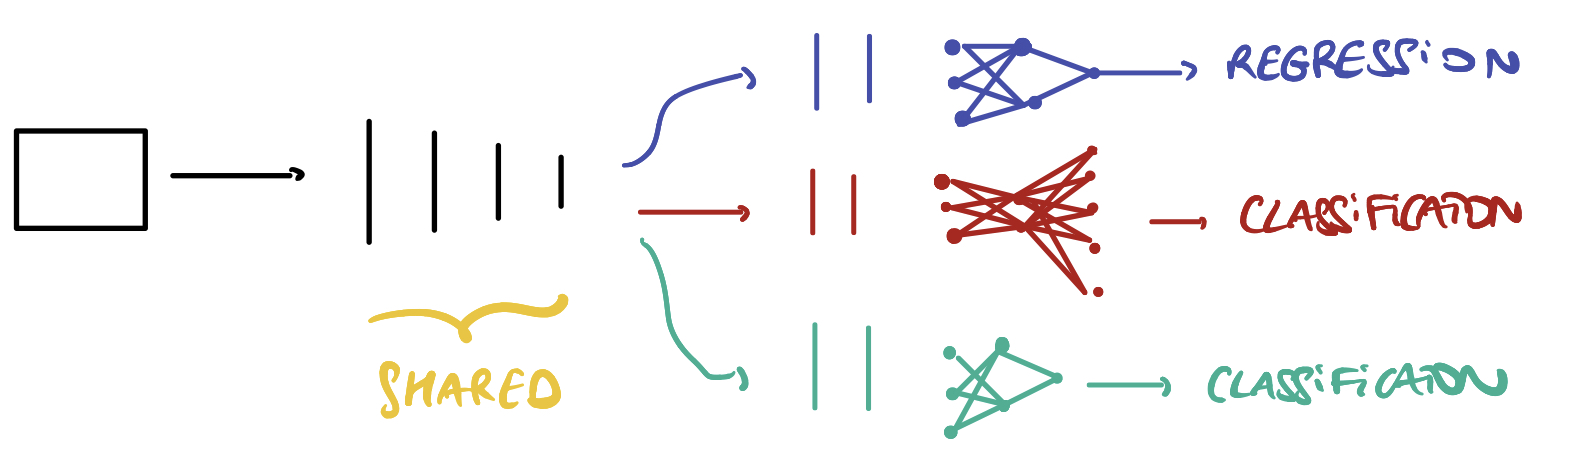

- Sharing Weights --> transfer learning과 같이 training 시간을 줄여줄 것이다.
- 3가지 task를 처리하기 위해 3x50 layers가 필요한 것이 아니라 단 몇가지 줄만 있으면 해결 가능하다.

Here's how this workshop is going to happen: 
1.  We're going to **load a multi-task learning dataset** named [UTK Face](https://susanqq.github.io/UTKFace/). It contains 24k images of faces, along with 3 labels: age, gender, and race/ethnicity.
2.  We are going to explore the dataset, and we'll realize that we need to solve **3 tasks**: binary classification (gender), multi-class classification (race), and regression (age).
3.  With PyTorch, we're going to learn how to **create a DataLoader that returns multiple labels**.
4.  To solve the tasks, we'll work with a **pretrained ResNet model**, **behead it**, and **create 3 new heads**.
5.  Finally, we'll **train the model** on a training dataset, and **test on the validation dataset**.
<p>

If you're familiar with PyTorch, this workshop might look simple, but it will be challenging to **get a great accuracy with it**. If you're new to PyTorch, you're gonna love it: We're going to **create everything from scratch**.

In [4]:
image_paths = sorted(glob.glob("UTKFace/*.jpg.chip.jpg"))

images = []
ages = []
genders = []
races = []

for path in image_paths:
    filename = path[8:].split("_")
    if len(filename)==4:
        images.append(np.array(Image.open(path)))
        ages.append(int(filename[0]))
        genders.append(int(filename[1]))
        races.append(int(filename[2]))

In [5]:
print(len(images))

23704


In [9]:
dataset_dict = {
    "gender_id": {
        0: "male",
        1: "female"
    },
    "race_id": {
        0: "White",
        1: "Black",
        2: "Asian",
        3: "Indian",
        4: "Other"
    },
    
}

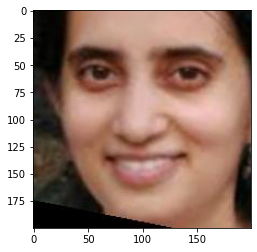

Age: 24
Gender: female
Race: Indian


In [10]:
idx = np.random.randint(len(images))# Hint: Try 19006 for someone who's gonna yell motherfucka at you!

plt.imshow(images[idx])
plt.show()

print("Age: "+str(ages[idx]))
print("Gender: "+str(dataset_dict['gender_id'][genders[idx]]))
print("Race: "+str(dataset_dict['race_id'][races[idx]]))

# Normalization
---

Regression을 할때, 데이터를 normalization을 해서 한다.

In [11]:
min_age_value, max_age_value = min(ages), max(ages)
log_age_values = np.log10(ages)
max_age_log_value = log_age_values.max()
print('MAX AGE VALUE', max_age_value)
print('MIN AGE VALUE', min_age_value)
print('MAX AGE LOG VALUE', max_age_log_value)

MAX AGE VALUE 116
MIN AGE VALUE 1
MAX AGE LOG VALUE 2.0644579892269186


In [72]:
def get_normalized_age_value(original_age_value):
    return (original_age_value - min_age_value)/(max_age_value - min_age_value)

def get_log_age_value(original_age_value):
    return np.log10(original_age_value)/max_age_log_value

def get_original_age_from_log_value(log_age_value):
    return np.exp(log_age_value) * max_age_log_value

def get_original_age_value(normalized_age_value):
    return normalized_age_value * (max_age_value - min_age_value) + min_age_value

# Create a Multi-Task DataLoader with PyTorch

- a dataset: 위에서 만든거 (images, ages, genders, races)
- a dataloader: This will convert our data in PyTorch format

In [13]:
# Just in case your images don't load properly
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [23]:
class UTKFace(Dataset):
    def __init__(self, image_paths):
        # Mean and Std for ImageNet
        mean=[0.485, 0.456, 0.406] # ImageNet
        std=[0.229, 0.224, 0.225] # ImageNet

        # Define the Transforms
        self.transform = transforms.Compose(
            [
                transforms.Resize((64, 64)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]
        )#TODO: Create 3 transforms: Resize, To Tensor, Normalize

        # Set Inputs and Labels
        self.image_paths = image_paths
        self.images = []
        self.ages = []
        self.genders = []
        self.races = []

        for path in image_paths:
            filename = path[8:].split("_")
            if len(filename)==4:
                self.images.append(path)
                self.ages.append(int(filename[0]))
                self.genders.append(int(filename[1]))
                self.races.append(int(filename[2]))
    
    def __len__(self):
         return len(self.images)

    def __getitem__(self, index):
        # Load an Image
        img = Image.open(self.images[index]).convert('RGB')#TODO: Load an Image
        # Transform it
        img = self.transform(img) #TODO: Transform it

        # Get the Labels
        age = self.ages[index] #TODO: 
        gender = self.genders[index] #TODO: 
        race = self.races[index] #TODO: 
        
        # Return the sample of the dataset
        sample = {'img': img, 'age': age, 'gender': gender, 'race': race}
        return sample

# Train/Test Split

In [24]:
import torch
from torch.utils.data import random_split
from torch.utils.data import DataLoader

In [25]:
# define the train and val splits
TRAIN_SPLIT = 0.7 #TODO: 
VAL_SPLIT = 0.3 #TODO: 

# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
num_train = round(TRAIN_SPLIT*len(image_paths))
num_val = round(VAL_SPLIT*len(image_paths))

print('Num of train samples', num_train)
print('Num of validation Samples', num_val)

Num of train samples 16595
Num of validation Samples 7112


In [27]:
(train_dataset, valid_dataset) = random_split(image_paths,[num_train, num_val],generator=torch.Generator().manual_seed(42))

# Dataloader

In [28]:
BATCH_SIZE = 64 #TODO: 

train_dataloader = DataLoader(UTKFace(train_dataset), shuffle=True, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(UTKFace(valid_dataset), shuffle=True, batch_size=BATCH_SIZE)

train_steps = len(train_dataloader.dataset) // BATCH_SIZE
val_steps = len(val_dataloader.dataset) // BATCH_SIZE

In [37]:
def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg)
    plt.show()
    

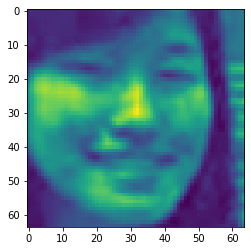

In [38]:
sample = next(iter(train_dataloader))

plt.imshow(sample['img'][1][1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


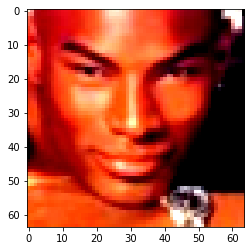

26
0.21739130434782608
male
Black


In [42]:
sample = next(iter(train_dataloader))

imshow(sample['img'][0])
plt.show()
print(sample["age"][0].item())
print(get_normalized_age_value(sample["age"][0].item()))


print(dataset_dict['gender_id'][sample["gender"][0].item()])
print(dataset_dict['race_id'][sample["race"][0].item()])

# 4 — Multi-Task Neural Network with PyTorch

In this part, we want to:
1. Define a Base Neural Network
2. Create the Heads
3. Train it
4. Test it

어떻게 하면 기존 모델에 원하는 nn을 붙이는지 알아보자!

In [43]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50, resnet101, resnet18, resnet34

In [51]:
net = resnet50(pretrained=True).to(device)

In [47]:
from torchviz import make_dot

make_dot(net(sample["img"].to(device)), params=dict(list(net.named_parameters()))).render("ResNet50", format="png")

'ResNet50.png'

## Create the HydraNet class

마지막 layer는 항상 net.fc라고 불린다. 만약 layer를 추가하고 싶다면, 이 뒤에 붙이면 되겠다.

예시를 살펴보자. 아래의 방식은 마지막 layer를 10 neuron output을 만들어내는 과정이다.

---
```python
self.net = models.resnet18(pretrained=True)
self.net.fc = nn.Linear(model.fc.in_features, 10)
```
---

---
또한 [OrderedDict](https://www.daleseo.com/python-collections-ordered-dict/) method를 이용해 layer set을 이어 붙일 수 있다. 
```python
from collections import OrderedDict
self.n_features = self.net.fc.in_features
self.net.fc1 = nn.Sequential(OrderedDict([
    ('linear', nn.Linear(self.n_features, self.n_features)),
    ('relu1', nn.ReLU()),
    ('final', nn.Linear(self.n_features, 1))
        ]
    )
)


In [53]:
from collections import OrderedDict

class HydraNetModified(nn.Module):
    def __init__(self, net):
        super().__init__()
        self.net = net
        self.n_features = self.net.fc.in_features
        self.net.fc = nn.Identity()
        
        # Age: 1 value, Linear is okay
        self.net.fc1 = nn.Sequential(OrderedDict([
            ('linear', nn.Linear(self.n_features, self.n_features)),
            ('relu1', nn.ReLU()),
            ('final', nn.Linear(self.n_features, 1))
        ]))

        # Gender: 2 value, (Male or Female) Binary Cross Entropy
        self.net.fc2 = nn.Sequential(OrderedDict([
            ('linear', nn.Linear(self.n_features, self.n_features)),
            ('relu1', nn.ReLU()),
            ('final', nn.Linear(self.n_features, 1))
        ]))

        # Race: 5 value, SoftMax
        self.net.fc3 = nn.Sequential(OrderedDict([
            ('linear', nn.Linear(self.n_features, self.n_features)),
            ('relu1', nn.ReLU()),
            ('final', nn.Linear(self.n_features, 5))
        ]))
        
    def forward(self, x):
        age_head = self.net.fc1(self.net(x))
        gender_head = self.net.fc2(self.net(x))
        race_head = self.net.fc3(self.net(x))
        return age_head, gender_head, race_head

In [54]:
model = HydraNetModified(net)
model.to(device)

HydraNetModified(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

In [55]:
make_dot(model(sample["img"].to(device)), params=dict(list(model.named_parameters()))).render("HydraNet", format="png")

'HydraNet.png'

In [56]:
race_loss = nn.CrossEntropyLoss() # SOFTMAX가 이미 되어있다.
gender_loss = nn.BCELoss() # No Softmax, Sigmoid
age_loss = nn.L1Loss()

lr = 1e-4
momentum = 0.09 # Meaning that we will go 9% with the previous direction
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# Train the Model

Pytorch에서 일반적인 학습 루프는 다음과 같다.
```python
losses = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for data in dataLoader:
        images, labels = data
        outputs = model(images)
        loss = criterion_label(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0) 

    epoch_loss = running_loss / len(dataloaders['train'])
    losses.append(epoch_loss)
    plt.plot(losses)
```

--- 
하지만 이것은 하나의 결과만을 보여주기에 우리는 아래와 같은 예시 형태로 바꾸어야 한다.

In [58]:
from sklearn.metrics import mean_absolute_error as mae

n_epochs = 100 #TODO: 

logger = {"train_loss": list(),
          "validation_loss": list(),
          "train_gender_loss": list(),
          "train_race_loss": list(),
          "train_age_loss": list(),
          "validation_gender_loss": list(),
          "validation_race_loss": list(),
          "validation_age_loss": list(),
          }

In [60]:
sig = nn.Sigmoid()

for epoch in range(n_epochs):
    model.train()

    total_training_loss = 0
    total_validation_loss = 0
    training_gender_loss = 0
    training_race_loss = 0
    training_age_loss = 0
    validation_gender_loss = 0
    validation_race_loss = 0
    validation_age_loss = 0

    for i, data in enumerate(train_dataloader):
        inputs = data['img'].to(device)
        age_label = get_normalized_age_value(data['age']).to(device)
        gender_label = data['gender'].to(device)
        race_label = data['race'].to(device)

        #TODO: Zero Grad
        optimizer.zero_grad()
        age_output, gender_output, race_output = model(inputs) # model forward가 된것. __call__이 된것
        
        loss_1 = race_loss(race_output, race_label)
        loss_2 = gender_loss(sig(gender_output), gender_label.unsqueeze(1).float())
        loss_3 = age_loss(age_output, age_label)

        loss = loss_1 + loss_2 + loss_3 # 이 부분 수정 가능함.

        #Backward
        loss.backward()
        #Step
        optimizer.step()
        total_training_loss += loss
        
        training_race_loss += loss_1.item()
        training_gender_loss += loss_2.item()
        training_age_loss += loss_3.item()
    print('EPOCH ', epoch+1)
    print("Training Losses: Race: {}, Gender: {}, Age: {}".format(loss_1, loss_2, loss_3))

    with torch.no_grad():
        model.eval()
        for i, data in enumerate(val_dataloader):
            inputs = data['img'].to(device) #
            age_label = get_normalized_age_value(data['age']).to(device)
            gender_label = data['gender'].to(device)
            race_label = data['race'].to(device)

            #TODO: Zero Grad
            optimizer.zero_grad()
            age_output, gender_output, race_output = model(inputs) # model forward가 된것. __call__이 된것

            loss_1 = race_loss(race_output, race_label)
            loss_2 = gender_loss(sig(gender_output), gender_label.unsqueeze(1).float())
            loss_3 = age_loss(age_output, age_label)

            loss = loss_1 + loss_2 + loss_3 # 이 부분 수정 가능함.
            total_validation_loss += loss

            validation_race_loss += loss_1.item()
            validation_gender_loss += loss_2.item()
            validation_age_loss += loss_3.item()
        print("Validation Losses: Race: {}, Gender: {}, Age: {}".format(loss_1, loss_2, loss_3))

    avgTrainLoss = total_training_loss / train_steps
    avgValLoss = total_validation_loss / val_steps
    
    print('Average Losses — Training: {} | Validation {}'.format(avgTrainLoss, avgValLoss))
    print() 
    avgTrainGenderLoss = training_gender_loss/len(train_dataloader.dataset)
    avgTrainRaceLoss = training_race_loss/len(train_dataloader.dataset)
    avgTrainAgeLoss = training_age_loss/len(train_dataloader.dataset)

    avgValGenderLoss = validation_gender_loss/len(val_dataloader.dataset)
    avgValRaceLoss = validation_race_loss/len(val_dataloader.dataset)
    avgValAgeLoss = validation_age_loss/len(val_dataloader.dataset)

    logger["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    logger["train_gender_loss"].append(avgTrainGenderLoss)
    logger["train_race_loss"].append(avgTrainRaceLoss)
    logger["train_age_loss"].append(avgTrainAgeLoss)
    
    logger["validation_loss"].append(avgValLoss.cpu().detach().numpy())
    logger["validation_gender_loss"].append(avgValGenderLoss)
    logger["validation_race_loss"].append(avgValRaceLoss)
    logger["validation_age_loss"].append(avgValAgeLoss)

/home/mint-lab/anaconda3/envs/dl_ws/lib/python3.9/site-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/mint-lab/anaconda3/envs/dl_ws/lib/python3.9/site-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([18, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


EPOCH  1
Training Losses: Race: 1.623277187347412, Gender: 0.6697083711624146, Age: 0.1519346833229065


/home/mint-lab/anaconda3/envs/dl_ws/lib/python3.9/site-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Validation Losses: Race: 1.533387541770935, Gender: 0.7296770811080933, Age: 0.19204534590244293
Average Losses — Training: 2.419455051422119 | Validation 2.367722272872925

EPOCH  2
Training Losses: Race: 1.4751545190811157, Gender: 0.6846187710762024, Age: 0.1450764685869217
Validation Losses: Race: 1.7408829927444458, Gender: 0.6660172939300537, Age: 0.1995498687028885
Average Losses — Training: 2.3292505741119385 | Validation 2.3270211219787598

EPOCH  3
Training Losses: Race: 1.5278687477111816, Gender: 0.6617816686630249, Age: 0.16303834319114685
Validation Losses: Race: 1.3102730512619019, Gender: 0.6275919675827026, Age: 0.14989307522773743
Average Losses — Training: 2.2959330081939697 | Validation 2.2983908653259277

EPOCH  4
Training Losses: Race: 1.2774300575256348, Gender: 0.665184736251831, Age: 0.13103169202804565
Validation Losses: Race: 1.5018086433410645, Gender: 0.6881848573684692, Age: 0.1321062594652176
Average Losses — Training: 2.268791437149048 | Validation 2.275

EPOCH  31
Training Losses: Race: 1.053112268447876, Gender: 0.3852630853652954, Age: 0.137538343667984
Validation Losses: Race: 1.094704508781433, Gender: 0.26839479804039, Age: 0.14815063774585724
Average Losses — Training: 1.648474097251892 | Validation 1.7289234399795532

EPOCH  32
Training Losses: Race: 0.9736186265945435, Gender: 0.49732887744903564, Age: 0.10502497106790543
Validation Losses: Race: 0.6147112250328064, Gender: 0.3199913799762726, Age: 0.13157060742378235
Average Losses — Training: 1.626206398010254 | Validation 1.713604211807251

EPOCH  33
Training Losses: Race: 1.196009635925293, Gender: 0.5724149346351624, Age: 0.10488990694284439
Validation Losses: Race: 0.4296824038028717, Gender: 0.615841805934906, Age: 0.2346118837594986
Average Losses — Training: 1.6073836088180542 | Validation 1.6850922107696533

EPOCH  34
Training Losses: Race: 1.2138007879257202, Gender: 0.43306297063827515, Age: 0.1560560166835785
Validation Losses: Race: 1.2252593040466309, Gender: 0.3

Validation Losses: Race: 0.8375861048698425, Gender: 0.3780383765697479, Age: 0.10238894075155258
Average Losses — Training: 1.1630462408065796 | Validation 1.4025707244873047

EPOCH  61
Training Losses: Race: 0.8190604448318481, Gender: 0.25086987018585205, Age: 0.10168202966451645
Validation Losses: Race: 1.1424424648284912, Gender: 0.17165455222129822, Age: 0.1447192281484604
Average Losses — Training: 1.151331901550293 | Validation 1.4026684761047363

EPOCH  62
Training Losses: Race: 0.6380261778831482, Gender: 0.09532838314771652, Age: 0.1295369565486908
Validation Losses: Race: 1.2606419324874878, Gender: 0.6021686792373657, Age: 0.1801149994134903
Average Losses — Training: 1.1397937536239624 | Validation 1.394323706626892

EPOCH  63
Training Losses: Race: 0.6173975467681885, Gender: 0.2974500060081482, Age: 0.16533416509628296
Validation Losses: Race: 1.083616852760315, Gender: 0.5753277540206909, Age: 0.14479169249534607
Average Losses — Training: 1.1279034614562988 | Validati

Validation Losses: Race: 0.5404297709465027, Gender: 0.040805380791425705, Age: 0.06583765894174576
Average Losses — Training: 0.8333272933959961 | Validation 1.293625831604004

EPOCH  90
Training Losses: Race: 0.941162645816803, Gender: 0.23843379318714142, Age: 0.1327751725912094
Validation Losses: Race: 0.2203184962272644, Gender: 0.4449014663696289, Age: 0.13533061742782593
Average Losses — Training: 0.8222619891166687 | Validation 1.2877838611602783

EPOCH  91
Training Losses: Race: 0.7490155100822449, Gender: 0.18036937713623047, Age: 0.135096475481987
Validation Losses: Race: 0.6528254151344299, Gender: 0.5006789565086365, Age: 0.1846679300069809
Average Losses — Training: 0.8055239915847778 | Validation 1.299526572227478

EPOCH  92
Training Losses: Race: 0.5731105804443359, Gender: 0.07375751435756683, Age: 0.10959196835756302
Validation Losses: Race: 0.1981552392244339, Gender: 0.399783730506897, Age: 0.1541604846715927
Average Losses — Training: 0.8018125295639038 | Validatio

In [61]:
torch.save(model.state_dict(), "best_model.pth")

나중가면 LR을 바꿀 수 있다. 

- first 30 epochs -> LR = 0.01
- next 30 epochs -> LR = 0.001
- rest -> LR = 0.0001

이러한 방식으로 overfitting을 피할 수 있겠다.

# Show the Results

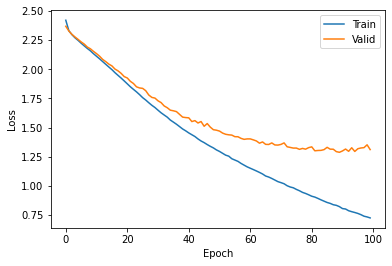

In [62]:
plt.plot(logger["train_loss"])
plt.plot(logger["validation_loss"])
plt.legend(['Train','Valid'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

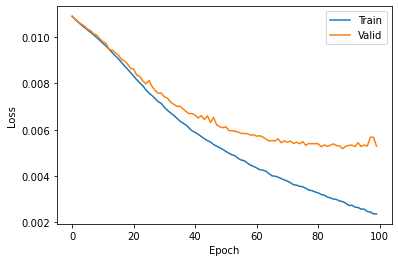

In [63]:
plt.plot(logger["train_gender_loss"])
plt.plot(logger["validation_gender_loss"])
plt.legend(['Train','Valid'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

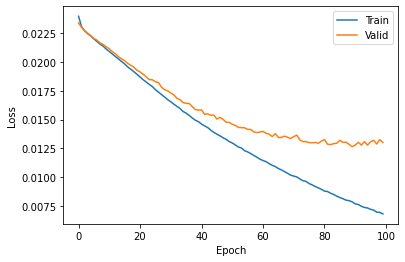

In [64]:
plt.plot(logger["train_race_loss"])
plt.plot(logger["validation_race_loss"])
plt.legend(['Train','Valid'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

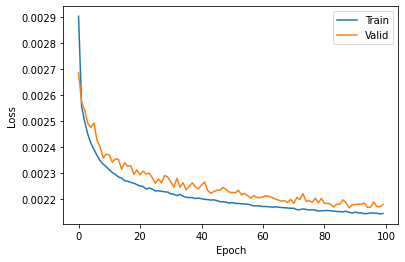

In [65]:
plt.plot(logger["train_age_loss"])
plt.plot(logger["validation_age_loss"])
plt.legend(['Train','Valid'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Inference

In [66]:
indexes = valid_dataset.indices
test_indices = indexes[0:10]

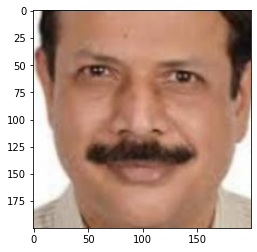

Age: 43 | Predicted: 44
Gender: male | Predicted: male
Race: Indian | Predicted: indian




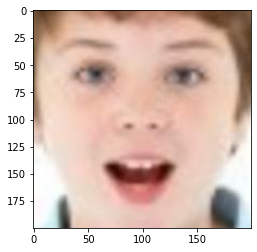

Age: 11 | Predicted: 48
Gender: male | Predicted: male
Race: White | Predicted: indian




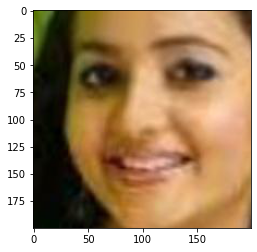

Age: 23 | Predicted: 43
Gender: female | Predicted: male
Race: Indian | Predicted: indian




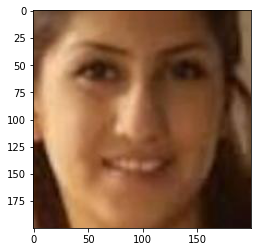

Age: 22 | Predicted: 53
Gender: female | Predicted: male
Race: Indian | Predicted: indian




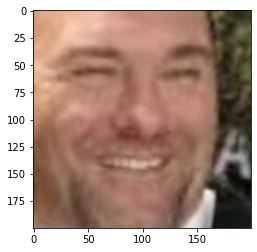

Age: 52 | Predicted: 50
Gender: male | Predicted: male
Race: White | Predicted: indian




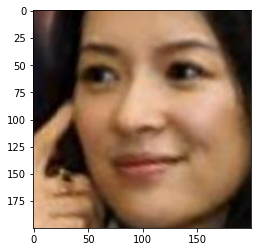

Age: 26 | Predicted: 38
Gender: female | Predicted: male
Race: Asian | Predicted: indian




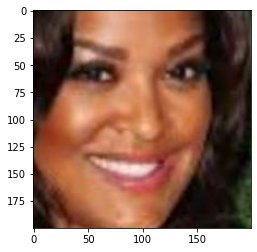

Age: 27 | Predicted: 45
Gender: female | Predicted: male
Race: Black | Predicted: indian




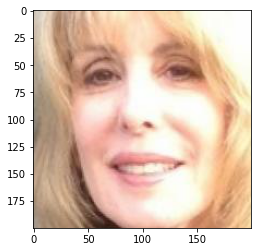

Age: 60 | Predicted: 47
Gender: female | Predicted: male
Race: White | Predicted: indian




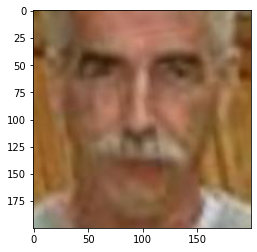

Age: 54 | Predicted: 56
Gender: male | Predicted: male
Race: White | Predicted: indian




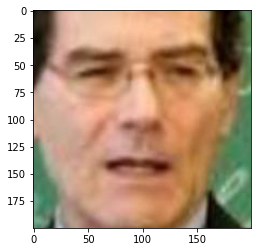

Age: 50 | Predicted: 50
Gender: male | Predicted: male
Race: White | Predicted: indian




In [75]:
for idx in test_indices:
    plt.figure()
    plt.imshow(images[idx])
    plt.show()

    image_norm = images[idx]/255.0
    image_norm = torch.from_numpy(image_norm).view(1, 3, image_norm.shape[0], image_norm.shape[1]).float()

    model.eval()
    age, gender, race = model(image_norm.to(device))

    predicted_age = get_original_age_value(age.squeeze(0)).item()

    print("Age:", str(ages[idx]), "| Predicted:", str(int(predicted_age)))

    sigmoid = nn.Sigmoid()
    out_gender = int(torch.round(sigmoid(gender)).item())
    gender_classes = ["male", "female"]
    print("Gender:", str(dataset_dict['gender_id'][genders[idx]]), "| Predicted:", str(gender_classes[out_gender]))

    out_race = torch.argmax(F.softmax(race, dim=1)).item()
    race_classes = ["white", "black", "asian", "indian", "other"]
    print("Race:", str(dataset_dict['race_id'][races[idx]]), "| Predicted:", str(race_classes[out_race]))
    print('\n')